Demonstrating my function to compare ranked lists
===============

A notebook to demonstrate [a function for comparing ranked lists](https://github.com/fomightez/text_mining), called `function to generate accounting of positions in two ranked lists.py`.



Provided input files:  
   Two similar, ranked list of yeast genes:

   * original_ranked_list.txt

   * similar_gene_list.txt

All other code is foud in the notebook.
    
------

Bringing in the data
--------------

The two lists of genes need to be brought into the notebook.

I am going to demonstrate by passing through a dataframe intermediate. I am doing this for a couple of reasons. Pandas provides an easy to read in tables and makes lists. Additionally, users may have the ranked lists already as dataframes and would like to see how to get their data working with the function.

These gene lists were saved without headers.

In [1]:
import pandas as pd
orginal_df = pd.read_table('original_ranked_list.txt',header=None, names=['gene'])
original_ranked_list = orginal_df['gene'].tolist()
similar_ranked_list = pd.read_table('similar_gene_list.txt',header=None, names=['gene'])['gene'].tolist()

If there had been a header line there, than changing to `header=0` probably would have addressed and then no need to supply column name because it will use the header.


Quick assessment of similarity via someone else's script
------------------------------------


Before using my function, let's get a measure of the similarity of the two lists.

Seems there is Python code for measuring similarity by [maslinych here](https://github.com/maslinych/linis-scripts/blob/master/rbo_calc.py). I learned of that code from inside the code implementation posited by [Comparing Ranked List](https://ragrawal.wordpress.com/2013/01/18/comparing-ranked-list/). I preferred the scores I was seeing with the one by maslinych when I was giving both of them toy data.



In [2]:
# %load https://raw.githubusercontent.com/maslinych/linis-scripts/f9ab60e94417c3bb465f107e93cde80168622e9b/rbo_calc.py
def calc_rbo(l1,l2,p):
    """ 
    Returns RBO indefinite rank similarity metric, as described in:
    Webber, W., Moffat, A., & Zobel, J. (2010). 
    A similarity measure for indefinite rankings. 
    ACM Transactions on Information Systems.
    doi:10.1145/1852102.1852106.
    """
    sl,ll = sorted([(len(l1), l1),(len(l2),l2)])
    s, S = sl
    l, L = ll
    
    # Calculate the overlaps at ranks 1 through l 
    # (the longer of the two lists)
    ss = set([])
    ls = set([])
    overs = {}
    for i in range(l):
        ls.add(L[i])
        if i<s:
           ss.add(S[i])
        X_d = len(ss.intersection(ls))
        d = i+1
        overs[d] = float(X_d)
    
    # (1) \sum_{d=1}^l (X_d / d) * p^d
    sum1 = 0
    for i in range(l):
        d=i+1
        sum1+=overs[d]/d*pow(p,d)
    X_s = overs[s]
    X_l = overs[l]

    # (2) \sum_{d=s+1}^l [(X_s (d - s)) / (sd)] * p^d
    sum2 = 0
    for i in range(s,l):
        d=i+1
        sum2+=(X_s*(d-s)/(s*d))*pow(p,d)

    # (3) [(X_l - X_s) / l + X_s / s] * p^l
    sum3 = ((X_l-X_s)/l+X_s/s)*pow(p,l)
    
    # Equation 32. 
    rbo_ext = (1-p)/p*(sum1+sum2)+sum3
    return rbo_ext

Using that code we can get a measure that tries to quantify how similar two lists are:



In [3]:
the_lists = [original_ranked_list,similar_ranked_list]
print('The lists of genes are the following sizes: {}.'.format([len(x) for x in the_lists])) 
sim_metric = calc_rbo(original_ranked_list,similar_ranked_list, p = 0.98)
print('The similarity metric determined: {:.3%}.'.format(sim_metric))


The lists of genes are the following sizes: [6918, 6918].
The similarity metric determined: 73.829%.


These are highly similar. Let's demonstrate that next.

The same list compared to itself gives a value of one, as can be demonstrated:

In [4]:
print("{:.3%}".format(calc_rbo(original_ranked_list, original_ranked_list, p = 0.98)))

100.000%


To really put the high value of similarity metric seen with the two list in context, what if for a few times we scramble one of the list of genes and compare that...

In [5]:
import random
for x in range(0, 7):
    copied_original_ranked_list = list(original_ranked_list) #must copy list first b/c shuffle is done in place
    random.shuffle(copied_original_ranked_list)
    print("{:.3%}".format(calc_rbo(original_ranked_list, copied_original_ranked_list, p = 0.98)))


0.749%
0.419%
0.517%
1.558%
0.600%
1.160%
0.181%


Assess the positions of items in the lists with my script
------------------

Now let's use my function to compare these lists and see how to work with the output we get.

To get more insight into the degree of similarity, we can assess the degree to which the gene identifiers shift between the ranked lists.

First load the function.

In [7]:
# %load https://raw.githubusercontent.com/fomightez/text_mining/5f42afe6646e29bde1c9039871e39d4b2f356f60/function%20to%20generate%20accounting%20of%20positions%20in%20two%20ranked%20lists.py
#!/usr/bin/env python3
# function to generate accounting of positions in a ranked list.py
__author__ = "Wayne Decatur" #fomightez on GitHub
__license__ = "MIT"
__version__ = "0.1.0"

# Originally written for comparing ranked gene lists but should work on any list
# where the order provided was a result of rank and the two lists are same
# length and CONTAIN NO DUPLICATES.
# Content & Arrangement of output inspired in a significant way by 'Rank list' 
# accessible clicking `Hide sample files and parameters [-]` at 
# [Rank Rank Hypergeometric Overlap:Graeber Lab Homepage:Simple Version(RRHO)](http://systems.crump.ucla.edu/rankrank/rankranksimple.php)

# Output meant to complement similarity metric calculation as first used in 
# `Examining Enrichment in Purified Mitochondria Samples Directly from the Salmon-Quantified Data.ipynb`

# Right now drafting to work for loading into a Jupyter notebook cell since I
# have been working a lot there and have need for this ability now. Could always
# expand into a stand-alone `runnable` or importable function/script later.

def generate_reports_for_ranked_lists_pos(lizt1,
                                        lizt2,
                                        return_dataframes = False,
                                        save_as = "tsv",
                                        output_file1 = "ranked list accounting.tsv",
                                        output_file2 = "ranked list row shift amounts.tsv"):
    """
    function to generate reports accounting for positions in two ranked lists.
    Provided lists should be equal in length WITH NO DUPLICATES.

    Takes:
    two lists to be compared.    * REQUIRED *
    Optional parameters may also be provided.

    Returns:
    either nothing or two dataframes depending on options user supplies when 
    function called.
    Typically, when it runs, it creates output tables in a user-defined 
    format that given an accounting of the postions in the two ranked lists.
    The default output is tsv.

    Output 1: 
    A table with the items in list one in order with the rank in list 1 and
    then the rank in list 2. The fourth column records the shift of the item in
    list 2 realtive list 1.
    For example if the first item in list 1 shifts to position 10 in list 2, 
    then the first half of the line would be:
    YDR190C 1   10  9

    Similar data makes up the second half of each line. The fifth column will be
    the id of the ranked list at that position with the other columns similar
    to the first half. 
    There is a header line so this would be the first two lines in this example:

    item_l1 pos_l1  pos_l2  ∆l1>l2  item_l2 pos_l2  pos_l1  ∆l2>l1
    YDR190C 1   10  9   Q0160   1   3   2


    Output 2:
    A table of the shifts is also produced. Highlights of this can be subsequently
    viewed with `df.describe()` or the distribution of shifts easily plotted 
    from this with pandas histograms.


    To make this easy, natural language is used to describe and number the items
    so that the first item is number 1 and so on. (No zero indexing.)

    OPTIONS:
    return_dataframes   Set this to True to return two dataframes.
    save_as             OPTIONS: 'do_not','excel','tsv','csv'. 'do_not' is for
                        when you don't want the output files saved and most 
                        likely would be used in conjunction with the 
                        `return_dataframes =  True` option.


    Typical exmple uses:
    generate_reports_for_ranked_lists_pos(l1,l2,save_as = "tsv")

    -OR-

    df1,df2 = generate_reports_for_ranked_lists_pos(l1,l2,return_dataframes = True)

    The latter being for the case where return dataframes.


    """


    # HELPER PARTS FOR FUNCTION
    def save_and_report(df, file_main,save_as):
        '''
        save df in desired format.
        Takes:
        DataFrame
        file main part of name, without extension
        format designator string

        Tries tsv if nothing matches allowed settings.

        returns: nothing, just does and reports
        '''
        if save_as.lower() == 'excel':
            try:
                import openpyxl
            except ImportError as iE:
                sys.stderr.write("Python Excel module 'openpyxl' not found. \nIf working in Jupyter notebook, run `!pip install openpyxl` without quotes in another cell.\nElse run on your command line without exclmation point.")
                sys.exit(1)
            df.to_excel(file_main+".xlsx",index = False) # after openpyxl installed
            sys.stderr.write("\nResults saved as "+file_main+".xlsx.")
        elif save_as.lower() == 'csv':
            df.to_csv(file_main+"csv",index = False)
            sys.stderr.write("\nResults saved as "+file_main+".csv.")
        elif save_as.lower() == 'do_not':
            sys.stderr.write("\nResults not saved as file since `do_not` assigned for `save_as`.")
        else:
            # if `tsv` or any other setting
            df.to_csv(file_main+".tsv", sep='\t',index = False)
            sys.stderr.write("\nResults saved as "+file_main+".tsv.")



    # MAIN PART OF FUNCTION
    # Preliminary check of lists.
    # The lists must be equal in length for this to work as written for now. 
    # (Duplicates will be checked for below.)
    assert len(lizt1) == len(lizt2), "The ranked lists must be equal in size. The provided lists are not equal in length."
    import sys
    if 'pd' not in sys.modules:
        import pandas as pd
    # First part is accounting:
    # Specify list of dataframes, and columns to use for later
    dfs_to_make = []
    col_headers_for_each_df = [
                            (
                            'item_l1',
                            'pos_l1',
                            'pos_l2',
                            '∆l1>l2'
                            ),
                            (
                            'item_l2',
                            'pos_l2',
                            'pos_l1',
                            '∆l2>l1'
                            )
                            ]
    # Process each list
    the_2_lists = [lizt1,lizt2]
    for indx, curr_lizt in enumerate(the_2_lists):
        # Verify no duplicates in each list
        len(curr_lizt) == len(set(curr_lizt))
        assert len(curr_lizt) == len(set(
            curr_lizt)), "Lists cannot contain duplicates. The provided list #{} contains duplicates".format(indx)
        other_lizt = the_2_lists[not indx] #works since 0 and 1 are equivalent
        # to True and False booleans; I cannot recall where I saw a trick like
        # this but useful here for toggle.
        # Make lists for recording accounting
        item_list = []
        item_pos_in_the_list = []
        item_pos_in_other_list = []
        item_change_relative_the_list = []
        #collect data relative current list
        for iindx, item in enumerate(curr_lizt):
            item_list.append(item)
            item_pos_in_the_list.append(iindx+1) #`+1` to keep number in report 
            #matching natural language where first item is numbered 1
            pos_in_other_list = other_lizt.index(item)
            item_pos_in_other_list.append(pos_in_other_list+1) #`+1` to keep 
            #number in report matching natural language where first item #1
            #print((pos_in_other_list - iindx)) # FOR DEBUNGGING ONLY
            item_change_relative_the_list.append((pos_in_other_list - iindx))
        #store results as dataframe
        dfs_to_make.append(pd.DataFrame(list(zip(
            item_list,
            item_pos_in_the_list,
            item_pos_in_other_list, 
            item_change_relative_the_list)),
            columns=col_headers_for_each_df[indx])
                        )
    # Concatenate dataframes side-by-side
    df_account = pd.concat((dfs_to_make[0], dfs_to_make[1]),axis=1)
    # Save dataframe
    import os
    output_file1_main = os.path.splitext(output_file1)[0] #gets without 
    # extension so that I can handle setting without relying on user
    save_and_report(df_account, output_file1_main,save_as)

    # Second part is making an accounting of the distribution of shifts:
    # focus relative first list because shifts considered from other direction 
    # will just be negative direction shifts for the same items.
    df_shifts = dfs_to_make[0][["∆l1>l2"]]
    df_shifts = df_shifts.rename(columns={'∆l1>l2':'shift'})
    df_shifts.sort_values('shift', ascending=True, inplace=True)
    df_shifts = df_shifts.reset_index(drop=True) #set index to match re-sorted
    #print (df_shifts) #FOR DEBUGGING
    # Save dataframe
    output_file2_main = os.path.splitext(output_file2)[0] #gets without 
    # extension so that I can handle setting without relying on user
    save_and_report(df_shifts, output_file2_main,save_as)


    

    if return_dataframes:
        return df_account, df_shifts
        #return df_account, df_distribution

def main():
    """ Main entry point of the script """
    pass

if __name__ == "__main__":
    """ This is executed when run from the command line """
    pass

'''
# FOR TESTING
l1 = ["a","c","b"]
l2 = ["a","b","c"]
generate_reports_for_ranked_lists_pos(l1,l2)

l3 = ["a","c","b","d","e","f","g","h"]
l4 = ["a","b","d","e","f","g","h","c"]
df_r1,df_r2 = generate_reports_for_ranked_lists_pos(l3,l4,output_file1 = "oth_ranked list accounting.tsv",return_dataframes = True)
df_r2.describe()
dffreq = df_r2['shift'].value_counts().reset_index() # column 'amount of rows shifted' in 
# this case were integers but strings and maybe even floats if unique, see https://pandas.pydata.org/pandas-docs/stable/generated/pandas.Series.value_counts.html
dffreq.columns = ['shift', 'count']
dffreq
# But frequency dataframe not needed as can just visualize directly from shifts dataframe
ax = df_r2.hist();
ax[0][0].set_xlabel("shift") # from https://stackoverflow.com/a/43239901/8508004
ax[0][0].set_ylabel("count") # from https://stackoverflow.com/a/43239901/8508004
ax[0][0].set_title("Distribution of shifts") #just tried it based on matplotlib and how set labels of axes above
# or as shown in current documentation, and combining with matplotlib settings
ax = df_r2.plot.hist(ec=(0.3,0.3,0.3,0.65),legend=False)
ax.set_xlabel("shift")
ax.set_ylabel("frequency")
ax.set_title("Distribution of shifts");
''';

Next, have the function generate a report and additional details on the two ranked lists. Saving as Excel files, just for illustration. These won't be viewable in the Jupyter system and will need to be downloaded and viewed locally. (In fact as a second desmonstration of the function I ran it below to make tab-separated format files that can be viewed in the Jupyter dashboard.)

In [28]:
df_accounting,df_shift = generate_reports_for_ranked_lists_pos(original_ranked_list,similar_ranked_list,save_as = "excel",output_file1 = "list_accounting.xlsx",output_file2 = "shift_list.xlsx",return_dataframes = True)
generate_reports_for_ranked_lists_pos(original_ranked_list,similar_ranked_list,output_file1 = "list_accounting.tsv",output_file2 = "shift_list.tsv")


Results saved as list_accounting.xlsx.
Results saved as shift_list.xlsx.
Results saved as list_accounting.tsv.
Results saved as shift_list.tsv.

Since we also generated and assigned dataframes we can view those here as they will give a nice overview and reveal what is in the saved tables, specifically Excel or tab-delimited files in this case, as the contents are the same.

In [9]:
df_accounting

,item_l1,pos_l1,pos_l2,∆l1>l2,item_l2,pos_l2,pos_l1,∆l2>l1
0,YCL052C,1,2,1,YOR238W,1,192,191
1,YFR031C,2,3,1,YCL052C,2,1,-1
2,YBR230C,3,4,1,YFR031C,3,2,-1
3,YLR238W,4,5,1,YBR230C,4,3,-1
4,YGR060W,5,6,1,YLR238W,5,4,-1
5,YGL066W,6,7,1,YGR060W,6,5,-1
6,YKL102C,7,8,1,YGL066W,7,6,-1
7,YKL113C,8,9,1,YKL102C,8,7,-1
8,YCR035C,9,10,1,YKL113C,9,8,-1
9,YOR308C,10,2566,2556,YCR035C,10,9,-1


In [11]:
df_shift

,shift
0,-6507
1,-6137
2,-6137
3,-6137
4,-6137
5,-6137
6,-6137
7,-6137
8,-6137
9,-6137


In [10]:
df_shift.describe()

,shift
count,6918.000000
mean,0.000000
std,474.498757
min,-6507.000000
25%,-3.000000
50%,16.000000
75%,31.000000
max,6280.000000


Some extreme shifts but most small as highlighted by the quantiles, (25%,50%,75%).
The mean should always be zero because there are no duplicates and the lists are both the same size. In another words if an item shifts, another item or items must shift as well to equal the amount needed to allow the item to have shifted.

Using the output to visualize the shifts
---------------------------

While you can explore the dataframes or see the Excel or tab-delimited files for more details, we can easily get some insight by looking at the distribution of the amounts of shifts in the rows that the gene identitifers undergo between the two ranked lists.


,shift
count,6918.000000
mean,0.000000
std,474.498757
min,-6507.000000
25%,-3.000000
50%,16.000000
75%,31.000000
max,6280.000000


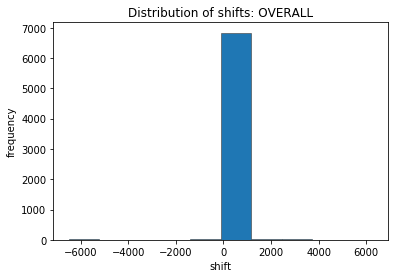

In [15]:
ax = df_shift.plot.hist(ec=(0.3,0.3,0.3,0.65),legend=False)
ax.set_xlabel("shift")
ax.set_ylabel("frequency")
ax.set_title("Distribution of shifts: OVERALL");
df_shift.describe()

So despite the min and mean shifts being extreme, similar shifts might be low in frequency because most around zero.

By comparison to a shuffled example(see below), enrichment of lower numbers is obvious.  
Although in the overall view the bins, look rather large, the range examined can further emphasize enrichment of lower numbers.

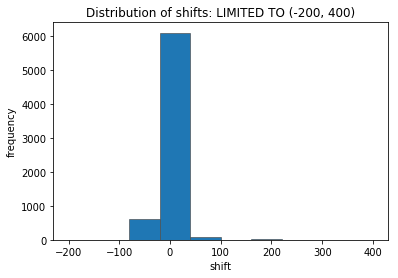

In [20]:
limit2_range= (-200,400)
ax = df_shift.plot.hist(ec=(0.3,0.3,0.3,0.65),legend=False, range=limit2_range)
ax.set_xlabel("shift")
ax.set_ylabel("frequency")
ax.set_title("Distribution of shifts: LIMITED TO {}".format(limit2_range));

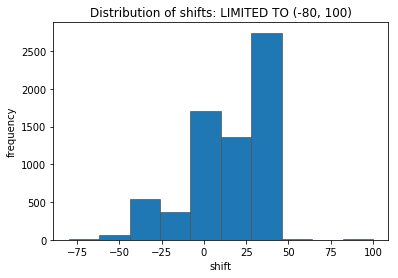

In [22]:
limit2_range= (-80,100)
ax = df_shift.plot.hist(ec=(0.3,0.3,0.3,0.65),legend=False, range=limit2_range)
ax.set_xlabel("shift")
ax.set_ylabel("frequency")
ax.set_title("Distribution of shifts: LIMITED TO {}".format(limit2_range));


**By contrast, if a shuffled list was compared...**  
In particular, note the y-axis scale.

In [25]:
import random
copied_gene_list = list(original_ranked_list) #must copy list first b/c shuffle is done in place
random.shuffle(copied_gene_list)
df_shufacc,df_shufshift = generate_reports_for_ranked_lists_pos(original_ranked_list,copied_gene_list, save_as = "do_not",return_dataframes = True)


Results not saved as file since `do_not` assigned for `save_as`.
Results not saved as file since `do_not` assigned for `save_as`.

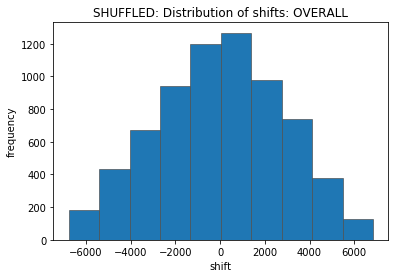

In [26]:
ax = df_shufshift.plot.hist(ec=(0.3,0.3,0.3,0.65),legend=False)
ax.set_xlabel("shift")
ax.set_ylabel("frequency")
ax.set_title("SHUFFLED: Distribution of shifts: OVERALL");